# **Rendu du projet** : ACTUARIAT ET DATA-SCIENCE

*Ibrahim EZ-ZAHRAOUY*

## 0. Importation des librairies

In [5]:
# Installer le package catboost
!pip install catboost

# Installer ipywidgets Python package
!pip install ipywidgets

# Activer l'extension de l'interface
!jupyter nbextension enable --py widgetsnbextension

# Scikit-optimize pour l'optimisation
!pip install scikit-optimize

# shap pour l'importance des fetures
!pip install shap

Enabling notebook extension jupyter-js-widgets/extension...
Paths used for configuration of notebook: 
    	/root/.jupyter/nbconfig/notebook.json
Paths used for configuration of notebook: 
    	
      - Validating: OK
Paths used for configuration of notebook: 
    	/root/.jupyter/nbconfig/notebook.json


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sklearn.model_selection import train_test_split
from catboost import CatBoostRegressor, cv, Pool
import skopt
from numpy import mean
from sklearn.model_selection import cross_val_score
from skopt.space import Integer
from skopt.space import Real
from skopt.space import Categorical
from skopt.utils import use_named_args
from skopt import gp_minimize
from sklearn.metrics import mean_squared_error
import shap
shap.initjs()

## 1. Données

### 1.1. Importation des données

In [7]:
# Importation des données
train = pd.read_csv("/content/drive/MyDrive/Study case/labeled_dataset.csv", sep = ';')
submission = pd.read_csv("/content/drive/MyDrive/Study case/scoring_dataset.csv", sep = ';')

In [8]:
train.head()

index   Age  Prime mensuelle Categorie socio professionnelle  \
0      0  58.0             40.0                        Etudiant   
1      2  27.0             26.0                           Cadre   
2      3  22.0              8.0                        Etudiant   
3      5  25.0             18.0                     Sans emploi   
4      6  54.0             22.0                           Cadre   

   Kilometres parcourus par mois  Coefficient bonus malus Type de vehicule  \
0                            973                      106              SUV   
1                            978                      136              SUV   
2                            771                       96         3 portes   
3                            372                      123         5 portes   
4                            981                       86         5 portes   

   Score CRM  Niveau de vie   Marque  Salaire annuel  Score credit  \
0        164           3762  Peugeot           20420           309   
1        153            986  Renault            6790           786   
2        111           2366  Peugeot           15140           320   
3        160           2058  Peugeot           14400           850   
4        148           3906  Renault           27350           895   

   Cout entretien annuel Benefice net annuel  
0                    801       54.9985582102  
1                    696       46.0788894792  
2                    765      -11.0482126237  
3                    758       16.7092144829  
4                    918       16.0576359837

In [9]:
print(f"Nombre de lignes d'entrainement : {len(train)}")
print(f"Nombre de lignes de prédiction : {len(submission)}")

Nombre de lignes d'entrainement : 1000
Nombre de lignes de prédiction : 300


### 1.2. Description des données

Ce jeu de données correspond à des données relatifs l'assurance.

Il est interessant de noter qu'il a été **intégralement généré**. Donc, **les relations entre les variables ou leurs valeurs pourraient ne pas être significatives ou reflétante de la réalité**.

 On définit quelques variables :
- **index**: Un identifiant unique pour chaque entrée dans le dataset.
- **Prime mensuelle**: la prime (potentiellement commerciale) d'assurance que l'assuré paie
- **Coefficient bonus malus** : reflète le comportement de conduite de l'assuré. Un bonus malus grand reflète une conduite imprudente.
- **Score CRM** : pareil que le bonus malus. Plus il est élevé plus la conduite de l'assuré est imprudente.
- **Score crédit** : évalue la solvabilité financière de l'assuré. Un score de crédit élevé indique une probabilité plus faible de défaut de paiement.
- **Cout entretien annuel** : du véhicule
- **Benefice net annuel** : le profit annuel généré par l'assuré pour l'assureur

Le but du projet est de prédire Le bénéfice net annuel étant donné un profil client spécifique. Il s'agit d'un problème de **régression**.

In [10]:
# Cible de prédiction
target = 'Benefice net annuel'

### 1.3. Qualité des données

In [11]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 14 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   index                            1000 non-null   int64  
 1   Age                              982 non-null    float64
 2   Prime mensuelle                  988 non-null    float64
 3   Categorie socio professionnelle  1000 non-null   object 
 4   Kilometres parcourus par mois    1000 non-null   int64  
 5   Coefficient bonus malus          1000 non-null   int64  
 6   Type de vehicule                 1000 non-null   object 
 7   Score CRM                        1000 non-null   int64  
 8   Niveau de vie                    1000 non-null   int64  
 9   Marque                           947 non-null    object 
 10  Salaire annuel                   1000 non-null   int64  
 11  Score credit                     1000 non-null   int64  
 12  Cout entretien annuel

#### 1.3.1. Erreurs

On remarque que la variable **Benefice net annuel** est de dtype object à la place de float64. Ceci pourrait être du à une erreur lors de la génération du dataset. En effet, certaines valeurs contiennent ',' comme séparateur décimal. On procède à la correction.

In [12]:
# Remplacer les ',' par des '.'
train["Benefice net annuel"] = train["Benefice net annuel"].apply(lambda x : float(x.replace(',', '.')))

#### 1.3.2. Valeurs manquantes

Le dataset contient des valeurs manquantes pour trois variables. Il est nécessaire de les traiter afin d'éviter des biais dans l'analyse ou bien des pertes d'information.

Text(0.5, 1.0, 'Missing value in the dataset')

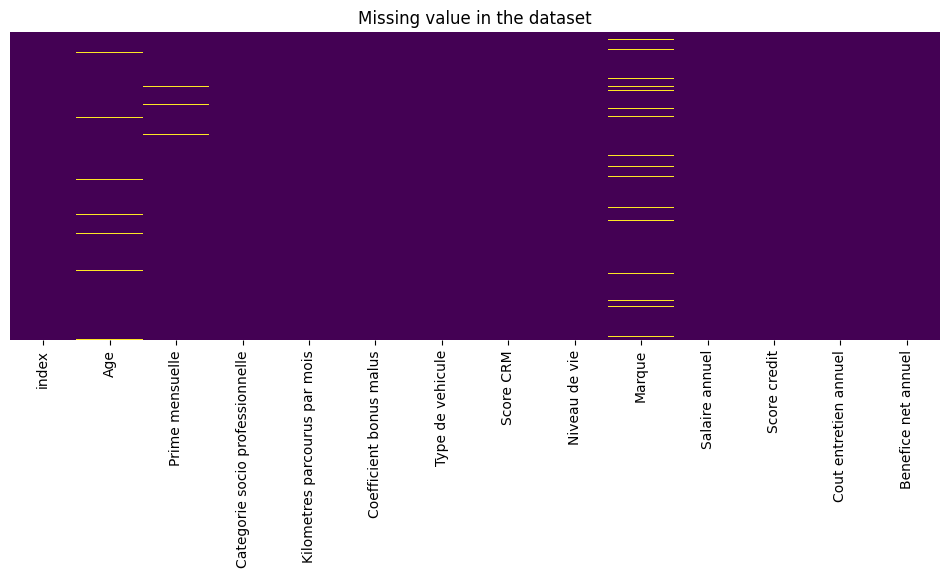

In [13]:
# Représenter les valeurs manquantes dans le dataset
plt.figure(figsize=(12,4))
sns.heatmap(train.isnull(), cbar=False, cmap='viridis', yticklabels=False)
plt.title('Missing value in the dataset')

Pour prendre la décision de comment on peut remplir les champs vide ou de la possibilité de les supprimer, on regarde la relation de la variable avec la cible.

<u> Variable **Marque** </u> :

On regarde la distribution de notre target par rapport aux différentes instances de Marque.

In [14]:
# Distribution de la cible par rapport à la marque
fig = px.box(train, x="Marque", y="Benefice net annuel")
fig.show()

Nous remarquons que la marque de la voiture n'a pas d'impact significatif sur le benefice net annuel. On peut pour le moment se contenter de renseigner les champs vides par une valeur aléatoire. Le choix de cette valeur dépend de la probabilité d'occurence de la catégorie dans le dataset.

In [17]:
# le nombre de champs vides dans la colonne Marque
num_missing = train['Marque'].isnull().sum()

# Décompte d'occurence de chaque instance dans le dataset
categories = train['Marque'].value_counts().to_dict()
print(categories)

# Calcul de probabilité d'occurence
length= len(train)
cat_prob = {key : value/(length - num_missing) for key, value in categories.items()}

# Génération des échantillons aléatoires pour remplir les champs vides
random_samples = np.random.choice(list(categories.keys()), size=num_missing, p=list(cat_prob.values()))

# Remplacement des champs vides par les échantillons aléatoires générés
train.loc[train['Marque'].isnull(), 'Marque'] = random_samples

{'Peugeot': 269, 'Renault': 238, 'Citroen': 195, 'Volkswagen': 106, 'Toyota': 89, 'Opel': 50}


<u> Variables **Age** et **Prime mensuelle**</u> :

Il y a 18/1000 lignes avec la variable age inconnue.

In [18]:
len(train)

1000

In [19]:
missing_age = train[train["Age"].isnull()]
missing_prime_mensuelle = train[train["Prime mensuelle"].isnull()]
without_mising_values = train[~(train["Prime mensuelle"].isnull()) & ~(train["Age"].isnull())]

fig = make_subplots(rows=2,
                    cols=2,
                    subplot_titles=("Dataset complet", "prime mensu & age =/= null", "age = null", "prime mensuelle = null" ),
                    x_title='Bénéfice',
                   y_title='Distribution (%)')

target_dist = go.Histogram(x=train["Benefice net annuel"],  histnorm='percent')
target_dist_without_missing = go.Histogram(x=without_mising_values["Benefice net annuel"],  histnorm='percent')
target_dist_missing_age = go.Histogram(x=missing_age["Benefice net annuel"],  histnorm='percent')
target_dist_missing_prime_mensuelle = go.Histogram(x=missing_prime_mensuelle["Benefice net annuel"],  histnorm='percent')

fig.add_trace(target_dist, row=1, col=1)
fig.add_trace(target_dist_without_missing, row=1, col=2)
fig.add_trace(target_dist_missing_age, row=2, col=1)
fig.add_trace(target_dist_missing_prime_mensuelle, row=2, col=2)

fig.update_layout(showlegend=False, title_text="Distribution du bénéfice")

Nous remarquons que la suppression des lignes contenant des valeurs manquantes pour les variables **Prime mensuelle** et **Age** n'impacte pas la distribution de probabilité de la cible **Bénéfice annuel net**. Donc, on peut se permettre de supprimer les lignes avec des valeurs manquantes.

On a prilvilégié la suppression aux méthodes d'imputation par des statistiques agrégéés (max, mmin, moyenne) afin de :
- Eviter d'augmenter la variabilité des données. Cela peut potentiellement rendre le modèle plus sensible aux valeurs aberrantes et affecter leur sensibilité.  
- Eviter l'incohérence avec le processus génératif des données.
- 30 lignes soit 3% des données supprimées.

In [20]:
# Supprimer les lignes avec Prime mensuelle ou age manquants
train = train.dropna()

In [21]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 970 entries, 0 to 998
Data columns (total 14 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   index                            970 non-null    int64  
 1   Age                              970 non-null    float64
 2   Prime mensuelle                  970 non-null    float64
 3   Categorie socio professionnelle  970 non-null    object 
 4   Kilometres parcourus par mois    970 non-null    int64  
 5   Coefficient bonus malus          970 non-null    int64  
 6   Type de vehicule                 970 non-null    object 
 7   Score CRM                        970 non-null    int64  
 8   Niveau de vie                    970 non-null    int64  
 9   Marque                           970 non-null    object 
 10  Salaire annuel                   970 non-null    int64  
 11  Score credit                     970 non-null    int64  
 12  Cout entretien annuel 

## 2. Statistiques descriptives

Il est interessant de regarder les statistiques descriptives afin de résumer les données et identifier les tendances ainsi que les relations entre les variables.

### 2.1. *Correlation*

<ipython-input-22-db3c45333cf2>:3: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.



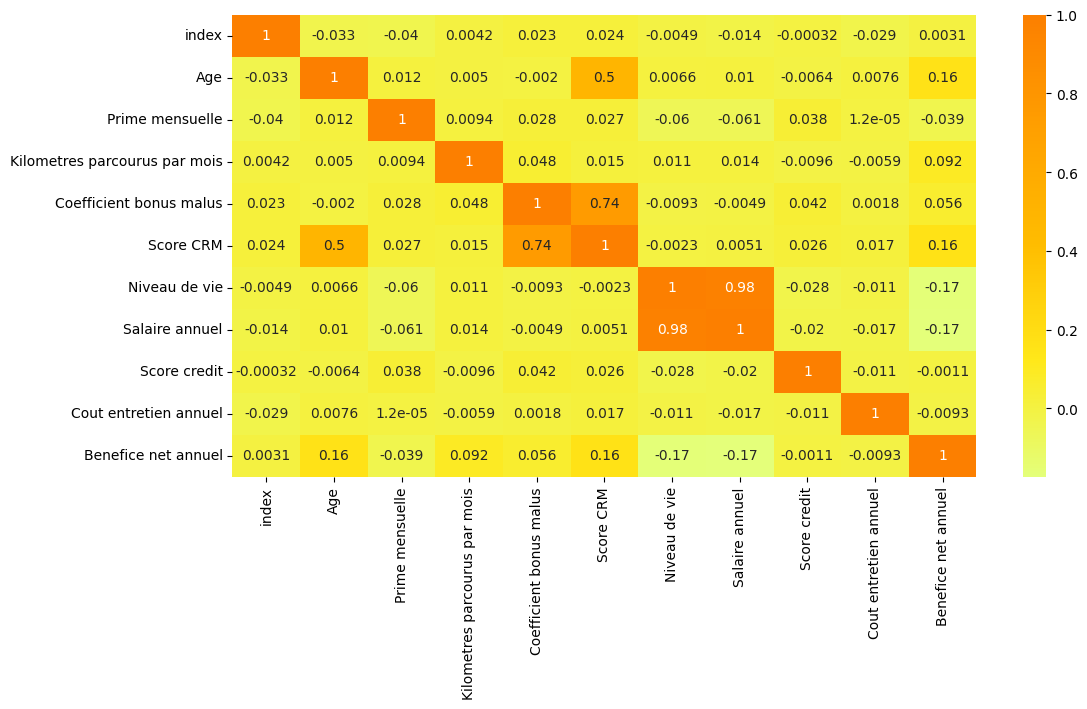

In [22]:
# Correlation Pearson entre les varibales
plt.figure(figsize=(12,6))
corr = train.corr()
sns.heatmap(corr, cmap='Wistia', annot=True);

Nous identifions **Salaire annuel** et **Niveau de vie** comme des variables fortement corrélées tout en ayant la même correlation avec la variable cible. Nous pouvons supprimer la variable **Niveau de vie**.


In [23]:
# Supprimer la variable Niveau de vie
train.drop(columns = ['Niveau de vie', 'index'], inplace = True)


Il y a d'autres variables corrélées, mais vu qu'on n'est pas sur un grand volume de données, n peut se contenter de les laisser.


### 2.4. Distributions


Maintenant, nous visualisons la ditribution des variables **numériques** ainsi que leurs relations avec la cible.

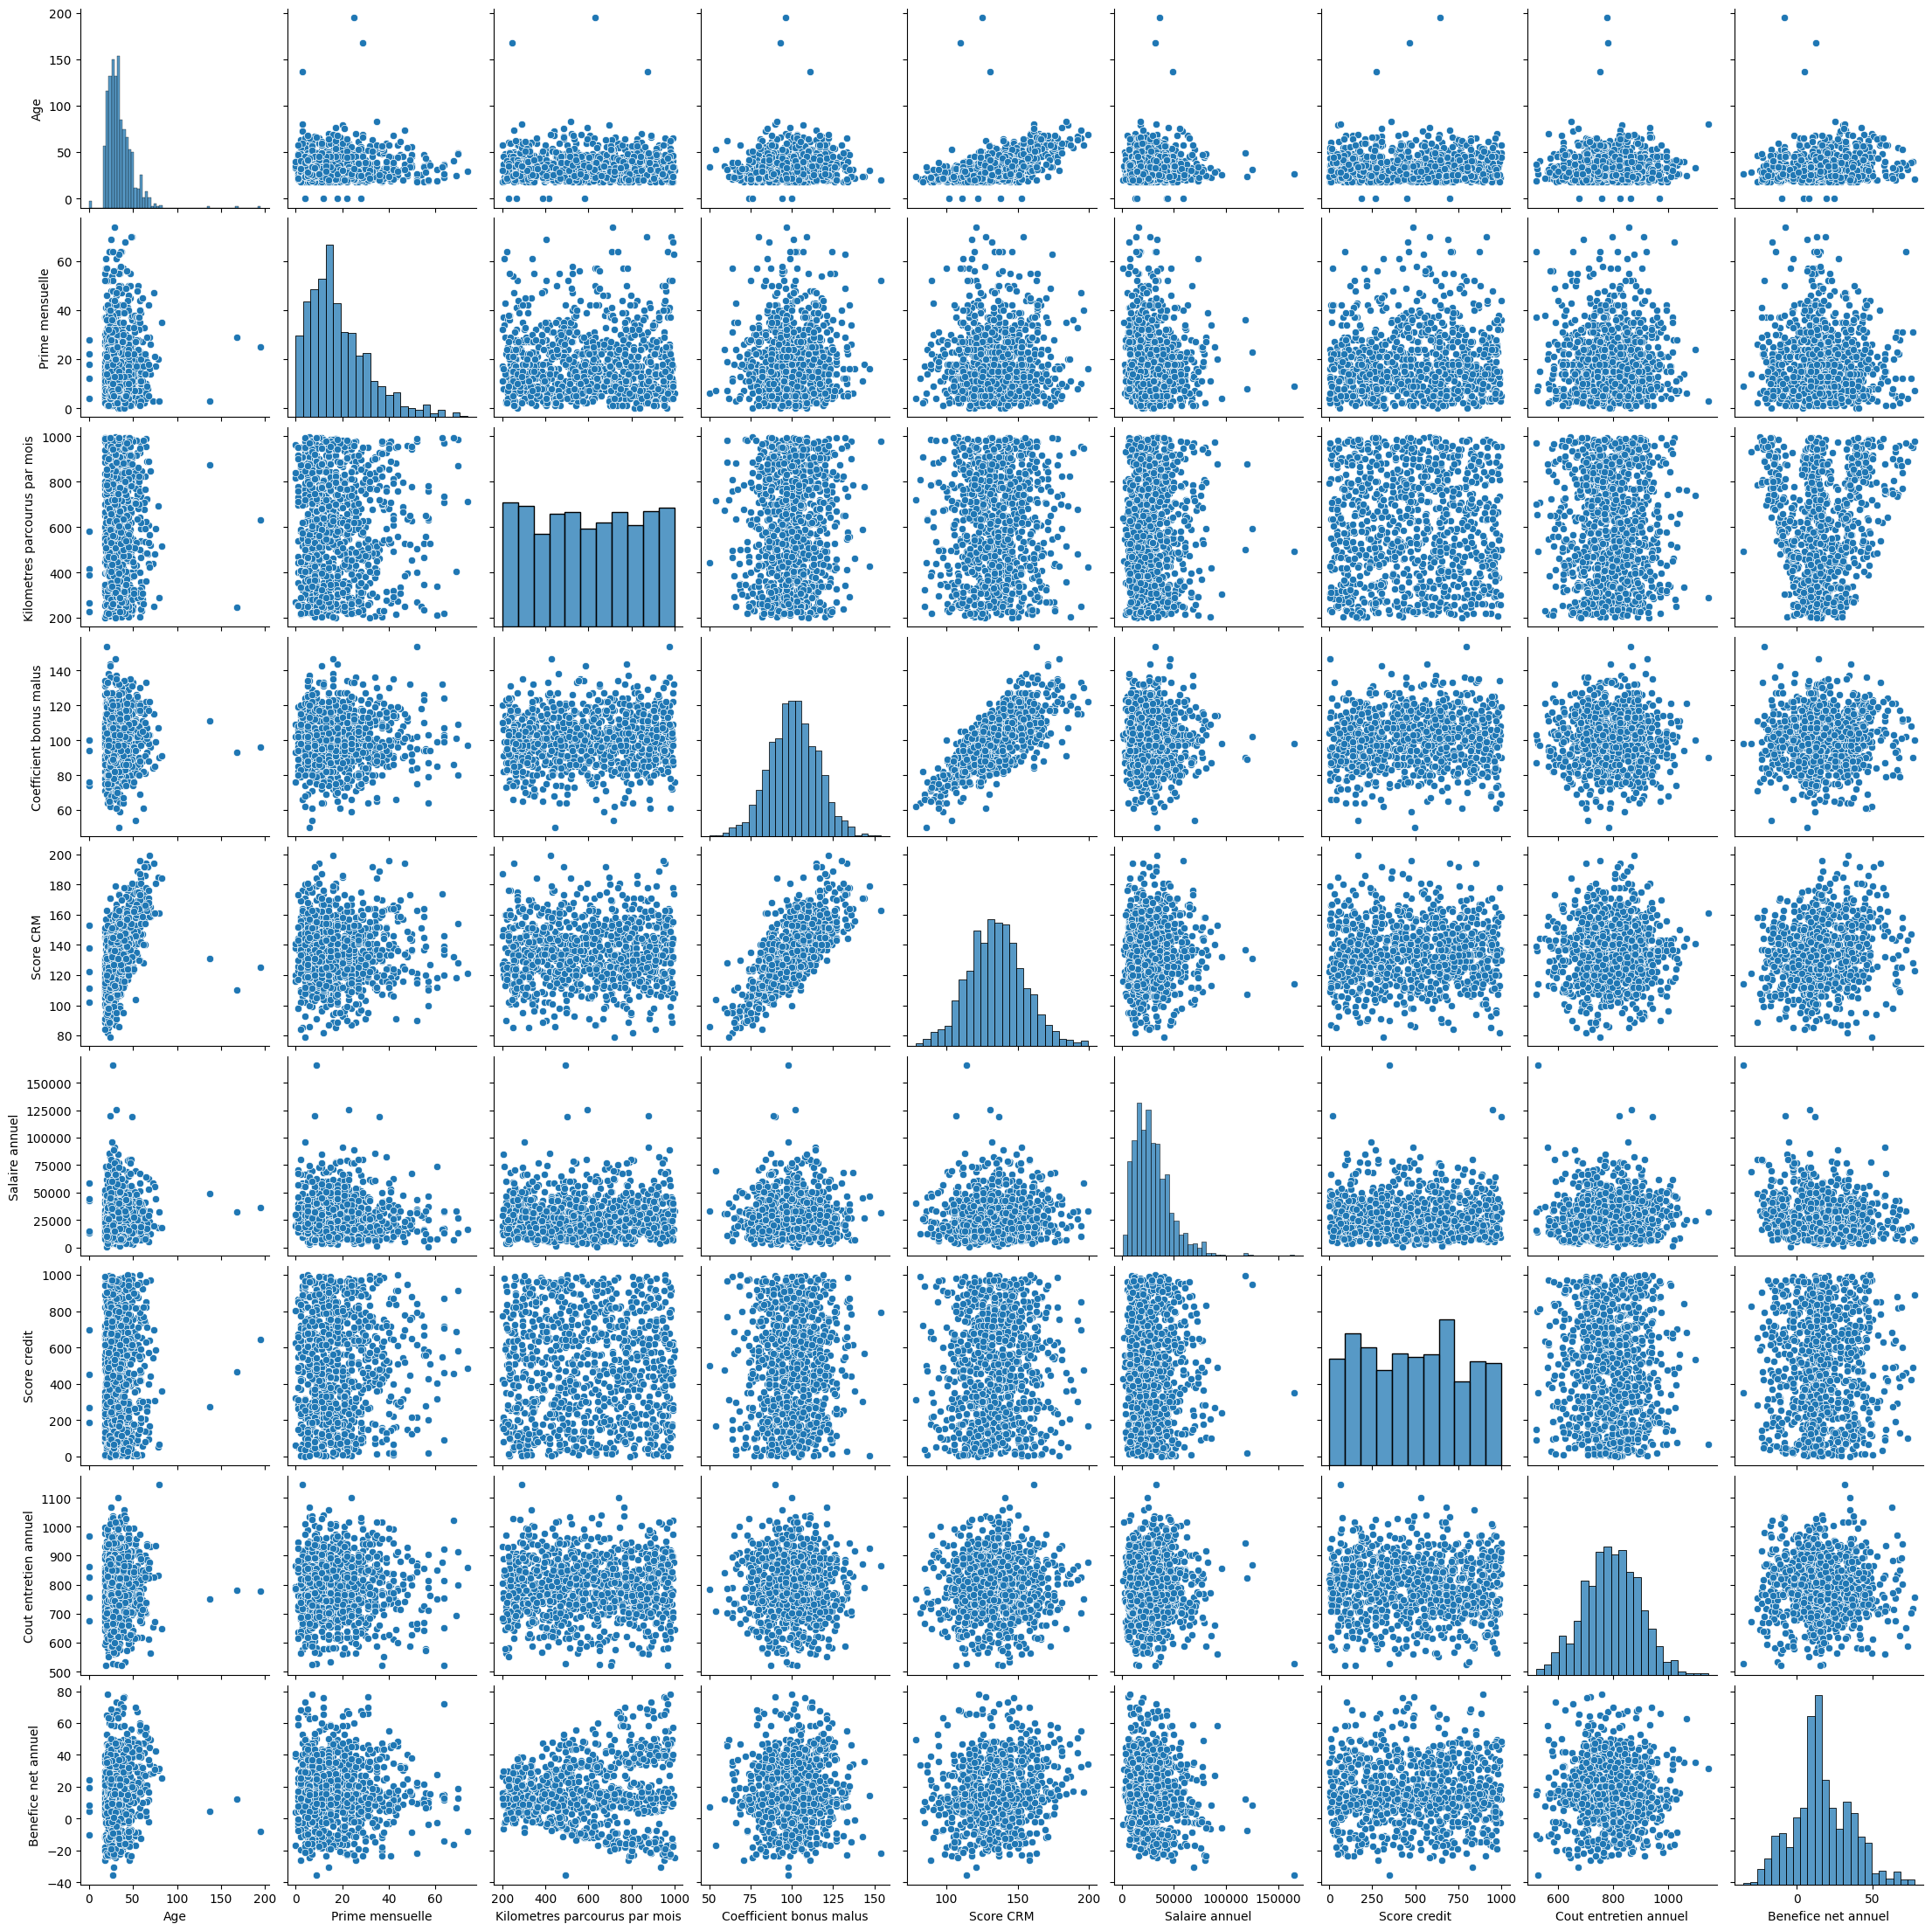

In [24]:
sns.pairplot(train[[col for col in train.columns]])
plt.show()

Le plot ci-dessus permet de visualiser les différentes distributions entres les variables **numériques**. Notamment les distributions de la variable cible par rapport aux autres.

<u>**Distribution de la variable cible par rapport aux varibales numériques**</u>


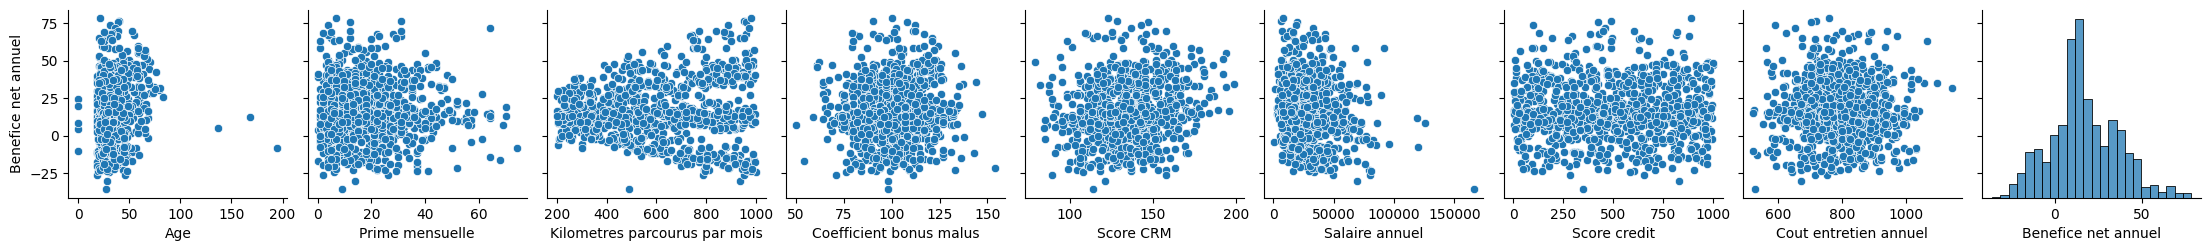

In [25]:
# Distribution de la variable cible par rapport aux varibales numériques
sns.pairplot(train[[col for col in train.columns if col != 'index']], y_vars = ["Benefice net annuel"])
plt.show()

<u>**Distribution de la variable cible par rapport aux varibales catégorielles**</u>


In [27]:
# Définir les colonnes catégorielles
cat_columns = train.select_dtypes(include=['object']).columns.tolist()

# Initier une figure
fig = make_subplots(rows=1,
              cols=len(cat_columns),
              subplot_titles=(cat_columns[0], cat_columns[1], cat_columns[2]),
              shared_yaxes=True)

# Boxplots
col1 = go.Box(x = train[cat_columns[0]], y=train[target], name =cat_columns[0])
col2 = go.Box(x = train[cat_columns[1]], y=train[target], name =cat_columns[1])
col3 = go.Box(x = train[cat_columns[2]], y=train[target], name =cat_columns[2])

# Ajout des traces dans la figures
fig.add_trace(col1, row = 1, col = 1)
fig.add_trace(col2, row = 1, col = 2)
fig.add_trace(col3, row = 1, col = 3)

# Visualisation
fig.update_layout(showlegend = False)
fig.show()

Nous remarquons que **Type de véhicule** est une variable discriminante pour le véhicule. Notamment, le bénéfice est plus important avec les gens qui ont des véhicules utilitaire qu'avec les gens avec des véhicules à 3 portes.

## 3. Modèle

### 3.1. Encodage

Nous pouvons ensuite encoder les données catégorielles en utilisant des techniques tels que **One hot encoding**. Or, vu qu'on utilisera un modèle catboost, lui-même se chargera de l'encodage. Il est déconseillé de traiter les variables catégorielles à la main si on compte utiliser un modèle catboost.

### 3.2. Split des données


Nous splitons les données en données d'entrainement et données de test.

#### 3.2.1 Split ordinaire

In [28]:
X = train.drop(columns=["Benefice net annuel"])
y = train[["Benefice net annuel"]]
X_train, X_test, y_train, y_test  = train_test_split(X, y, test_size = 0.2, random_state = 0)

Il est interessant de faire attention à préserver la distribution de la variable cible quand on split les données afin de préserver la représentativité.

Pour examiner si la méthode de split ordinaire préserve la représentativité, on regarde la distribution de **y_test** en comparaison avec celle de **y_train**.

In [29]:
fig = make_subplots(rows=1,
                    cols=2,
                    subplot_titles=("y_train", "y_test"),
                    x_title='Bénéfice',
                   y_title='Distribution (%)',
                   shared_yaxes = True)

y_train_dist = go.Histogram(x=y_train["Benefice net annuel"],  histnorm='percent')
y_test_dist = go.Histogram(x=y_test["Benefice net annuel"],  histnorm='percent')

fig.add_trace(y_train_dist, row = 1, col = 1)
fig.add_trace(y_test_dist, row = 1, col = 2)

fig.update_layout(showlegend=False, title_text="distribution de y_train vs y_test")

Nous remarquons qu'un split "normal" des données en données d'entrainement et données de test ne conserve pas la distribution de la variable cible.

Donc, nous allons remédier à ceci en utilisant une forme de stratification en créant des intervalles ou des catégories à partir des données numériques, puis en effectuant la séparation.

#### 3.2.2 Split stratifié

In [30]:
# Convertir y en intervalles/catégories
y_serie = y.iloc[:,0]

# min, max
y_min, y_max = min(y_serie), max(y_serie)

# spécifier les intervalles à stratifier. Ainsi, pour chaque intervalle de valeurs,
# nous prenons toujours une même proportion (ici 20%)
bins = [int(y_min) + 5*(i-1) for i in range(0, int(((y_max-y_min)/5+3))) if i!=1]
y_binned = pd.cut(y.iloc[:,0], bins=bins, labels=False)

#Effectuer la séparation entrainement-test tout en maintenant la distribution de y_binned
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y_binned)

Ensuite, nous visualisons la distribtion.

In [31]:
# Visualiser la dictribution
fig = make_subplots(rows=1,
                    cols=2,
                    subplot_titles=("y_train", "y_test"),
                    x_title='Bénéfice',
                   y_title='Distribution (%)',
                   shared_yaxes = True)

y_train_dist = go.Histogram(x = y_train["Benefice net annuel"],  histnorm='percent')
y_test_dist = go.Histogram(x = y_test["Benefice net annuel"],  histnorm='percent', xbins=dict(start=min(bins),end=max(bins),size=5))

fig.add_trace(y_train_dist, row = 1, col = 1)
fig.add_trace(y_test_dist, row = 1, col = 2)

fig.update_layout(showlegend=False, title_text="distribution de y_train vs y_test")

Nous remarquons qu'avec la méthode de split stratifié, nous avons réussi à préserver la distribution.

### 3.3. Tuning des hyperparamètres

Catboost se charge du traitement des varaibles catégorielles. Il suffit de les lui identifier.

In [32]:
# Variables catégorielles
cat_features = train.select_dtypes(include=['object']).columns.tolist()

#### 3.3.1. Pas d'apprentissage et Profondeur (optimisatin bayésienne)

D'abord, nous optimisons le pas d'apprentissage (**learning_rate**) et la profondeur des arbres (**depth**) en parallèle afin de trouver une combinaison de ces deux hyperparamètres qui fonctionne bien ensemble et qui offre un bon équilibre entre la vitesse d'apprentissage et la capacité de modélisation.

Pour ce faire nous utlisons l'optimisation bayésienne grâce au module scikit-optimize. C'est une méthode qui consiste à utiliser les processus gaussiens qui généralisent le concept de loi normale aux fonctions. Après chaque espérience, l'algorithme identifie les points à fort potentiel qui correpondent au minimum et qui permettent d'explorer davantage d'intervalles.

Le modèle utilisé est **CatboostRegressor**. Pour chaque tuple de valeurs à tester donné, on procède à une **validation croisée** avec 4 folds. L'optimisation bayésienne à trouver **learning_rate** et **depth** qui minimisent la fonction objective : **moyenne des scores RMSE des folds** obtenue pour chaque test.

Pur les paramètres du modèle :
- **iterations** : Le nombre d'itérations (ou arbres) à construire lors de l'entraînement du modèle. Plus le nombre d'itérations est élevé, plus le modèle sera complexe et précis, mais cela peut également augmenter le temps d'entraînement.
- **loss_function** : La fonction de perte utilisée pour guider l'apprentissage du modèle. Dans ce cas, 'RMSE' indique que le modèle utilise l'erreur quadratique moyenne (Root Mean Squared Error) comme mesure de perte à minimiser.
- **od_wait** : Le nombre d'itérations à attendre (patience) pour déterminer si l'erreur de validation croisée s'améliore. Si aucune amélioration n'est observée pendant ce nombre d'itérations, l'entraînement peut s'arrêter plus tôt pour éviter le surapprentissage.

Si on fixe **od_wait** on peut mettre une grande valeur pour **iterations** car de toute façon le modèle detecte l'overfitting quand il n'y a plus d'amélioration sur la base de validation.

In [33]:
# definir l'espace de recherche des hyperparametres
search_space = list()
search_space.append(Real(1e-3, 0.5, 'log-uniform', name='learning_rate'))
search_space.append(Integer(2, 7, name='depth'))

# definir la fonction utilisée pour évaluer les configurations
@use_named_args(search_space)
def evaluate_model(**params):

    # Choisir une configuration
    print(params)

    # Ce n'est aps grave d'utiliser un si grand nombre d'itération car le paramètre
    # od_wait permet de stopper les itérations quand il n y a pas d'amélioration
    # de performances sur la base de validation
    default_params = {'iterations' : 10_000,
                     'loss_function' : 'RMSE',
                     'od_wait' : 20,
                     'use_best_model' : True,
                     'verbose' : False,
                     'random_seed' : 0,
                     'cat_features' : cat_features}
    all_params = {**params, **default_params}

    # Data d'entrainement
    data_pool = Pool(X_train, y_train, cat_features=cat_features)

    # Validation croisée
    cv_result = cv(data_pool, all_params, fold_count=4, seed=0, shuffle=True)

    # calculer le score RMSE moyen pour l'essaie
    result = min(cv_result["test-RMSE-mean"])

    return result

# Chercher le min de la fonction objective sur le search_space
result = gp_minimize(evaluate_model, search_space)

# Résultats :
print('Best RMSE: %.3f' %  result.fun)
print('Best Parameters: %s' % (result.x))

{'learning_rate': 0.01783548351378194, 'depth': 4}
Training on fold [0/4]

bestTest = 1.855818515
bestIteration = 2448

Training on fold [1/4]

bestTest = 1.254317465
bestIteration = 2855

Training on fold [2/4]

bestTest = 1.759281544
bestIteration = 2339

Training on fold [3/4]

bestTest = 1.583494839
bestIteration = 1535

{'learning_rate': 0.021185855279325854, 'depth': 5}
Training on fold [0/4]

bestTest = 2.01332105
bestIteration = 1873

Training on fold [1/4]

bestTest = 1.255209332
bestIteration = 2851

Training on fold [2/4]

bestTest = 1.808922249
bestIteration = 1987

Training on fold [3/4]

bestTest = 1.628172076
bestIteration = 1702

{'learning_rate': 0.0053417303134517926, 'depth': 3}
Training on fold [0/4]

bestTest = 1.667980232
bestIteration = 9999

Training on fold [1/4]

bestTest = 1.423479648
bestIteration = 7629

Training on fold [2/4]

bestTest = 2.503738825
bestIteration = 5862

Training on fold [3/4]

bestTest = 1.881668564
bestIteration = 4140

{'learning_rate':

In [34]:
# Meilleur learning_rate
lr_best = result.x[0]

# Meilleur depth
depth_best = result.x[1]

# Meilleur nombre d'itérations
iter_best = 1130

On obtient la meilleure performance (**RMSE = 1.46** sur les données de validation) pour **learning_rate = 0.05947940568900549** et **depth = 3**.

#### 3.3.2. Régularisation

Afin de contrôler davantage la compléxité du modèle et éviter que la variance soit trop élevé, nous optimisons l'hyperparamètre **l2_leaf_reg**.

**l2_leaf_reg** est un hyperparamètre utilisé dans l'algorithme CatBoost pour appliquer une régularisation L2 (régularisation Ridge) aux poids des feuilles des arbres de décision construits pendant l'entraînement. La régularisation L2 ajoute une pénalité proportionnelle au carré des valeurs des poids des caractéristiques, ce qui a pour effet de limiter leur croissance excessive et de réduire le risque de surapprentissage.

In [35]:
# Paramètres du modèle
params = {'iterations' : 10_000,
          'learning_rate' : lr_best,
          'depth' : depth_best,
          'loss_function' : 'RMSE',
          'od_wait' : 20,
          'use_best_model' : True,
          'verbose' : False,
          'random_seed' : 0,
          'cat_features' : cat_features}

# Valeurs de l2_leaf_reg à tester
l2_leaf_reg_values = [1e-3, 2e-3, 5e-3, 7e-3, 1e-2, 2e-2, 5e-2, 7e-2, 0.1, 1, 5, 10]

# Listes pour sauvegarder les résultats des validations croisées
cv_means=[]
cv_vars=[]

# Effectuer une validation croisée par valeur de l2_leaf_reg et stocker les résultats
for l2_leaf_reg in l2_leaf_reg_values:
  # Data
  data_pool = Pool(X_train, y_train, cat_features=cat_features)

  # Validation croisée
  cv_result = cv(data_pool, {**params, **{'l2_leaf_reg' : l2_leaf_reg}}, fold_count=4, seed=0, shuffle=True)

  # Indice du meilleur score moyen
  index_min = cv_result['test-RMSE-mean'].idxmin()

  # Score moyen obtenu avec la validation croisée
  mean = cv_result.loc[index_min, "test-RMSE-mean"]
  cv_means.append(mean)

  # Variance des scores
  var = cv_result.loc[index_min, "test-RMSE-std"]
  cv_vars.append(var)

Training on fold [0/4]

bestTest = 1.804495115
bestIteration = 919

Training on fold [1/4]

bestTest = 1.176491108
bestIteration = 1251

Training on fold [2/4]

bestTest = 2.029604771
bestIteration = 717

Training on fold [3/4]

bestTest = 1.6418941
bestIteration = 703

Training on fold [0/4]

bestTest = 1.815968938
bestIteration = 791

Training on fold [1/4]

bestTest = 1.270150338
bestIteration = 792

Training on fold [2/4]

bestTest = 2.078128113
bestIteration = 598

Training on fold [3/4]

bestTest = 1.546604412
bestIteration = 899

Training on fold [0/4]

bestTest = 1.771644649
bestIteration = 975

Training on fold [1/4]

bestTest = 1.329806207
bestIteration = 681

Training on fold [2/4]

bestTest = 1.622710859
bestIteration = 1236

Training on fold [3/4]

bestTest = 1.474312542
bestIteration = 1432

Training on fold [0/4]

bestTest = 1.795601262
bestIteration = 977

Training on fold [1/4]

bestTest = 1.112850204
bestIteration = 1361

Training on fold [2/4]

bestTest = 1.631883344

Maintenant, Nous visualisons l'effet de **l2_leaf_reg** sur les performance du modèle.

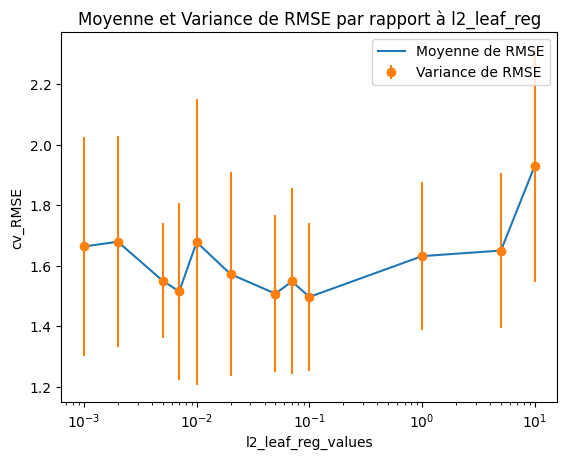

In [36]:
# Echelle log pour l2_leaf_reg
# Tracer la moyenne
plt.semilogx(l2_leaf_reg_values, cv_means, label='Moyenne de RMSE')

# Tracer la variance
plt.errorbar(l2_leaf_reg_values, cv_means, yerr=cv_vars, fmt='o', label='Variance de RMSE')

# Ajouter des titres et des légendes
plt.xlabel('l2_leaf_reg_values')
plt.ylabel('cv_RMSE')
plt.title('Moyenne et Variance de RMSE par rapport à l2_leaf_reg')
plt.legend()

# Afficher le graphique
plt.show()

Nous remarquons que la régularisation n'a pas d'effet sur l'amélioration du pouvoir de généralisation du modèle. La régularisation s'avère non nécessaire, d'autant plus que le modèle n'est pas complexe.

### 3.3.3. Test sur la base de test.

Maintenant, nous mesurons le pouvoir de généralisation du modèle en utilisant la base de test qui n'a pas été utilisée lors de l'entrainement.

In [37]:
# Data d'entrainement
data_pool = Pool(X_train, y_train, cat_features=cat_features)

# Paramètres optimaux
params = {'iterations' : iter_best,
          'learning_rate' : lr_best,
          'depth' : depth_best,
          'loss_function' : 'RMSE',
          'verbose' : False,
          'random_seed' : 0,
          'cat_features' : cat_features}

# Entrianement du modèle
cat_model = CatBoostRegressor(**params)
cat_model.fit(X_train,
              y_train,
              plot=True)

# Prédiction sur la bas e de test
y_pred = cat_model.predict(X_test,
                  prediction_type=None,
                  verbose=True)

# Récupérer le sccore par rapport aux valeurs réelles
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"RMSE de test est : {rmse_test}")

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

RMSE de test est : 1.3795619905003735



Nous remarquons que RMSE du test est proche de RMSE de validation (même inférieur!). Ce qui veut dire que le modèle a un bon pouvoir de généralisation.

**Les hyperparamètres sont alors validés !**

### 3.4 Modèle final

Maintenant, pour le modèle final,  on entraine le modèle sur la base d'entrainement entière en utilisant les hyperparamètres optimaux, tout en gardant un oeil sur la variance et le biais du modèle en utilisant la base de test cette fois comme base de validation pour le mdèle. Ainsi, ceci permettra d'entrainer le modèle sur plus de données tout en évitant l'overfitting.

In [ ]:
# Data d'entrainement
data_pool = Pool(X_train, y_train, cat_features=cat_features)

# Data de validation
eval_pool = Pool(X_test, y_test, cat_features=cat_features)

# Paramètres optimaux
params = {'iterations' : 10_000,
          'learning_rate' : lr_best,
          'depth' : depth_best,
          'loss_function' : 'RMSE',
          'use_best_model' : True,
          'od_wait' : 20,
          'verbose' : False,
          'random_seed' : 0,
          'cat_features' : cat_features}

# Entrainement du modèle
cat_model_final = CatBoostRegressor(**params)
cat_model_final.fit(X_train,
              y_train,
              plot=True,
              eval_set=eval_pool,
              plot_file='/content/drive/MyDrive/Study case/plot_train.html',
              verbose_eval=True)

On obtient pour 845 itérations :
- RMSE d'entrainement : 1.07
- RMSE de validation : 1.37

<u>**Courbe d'entrainement/validation**<u/>

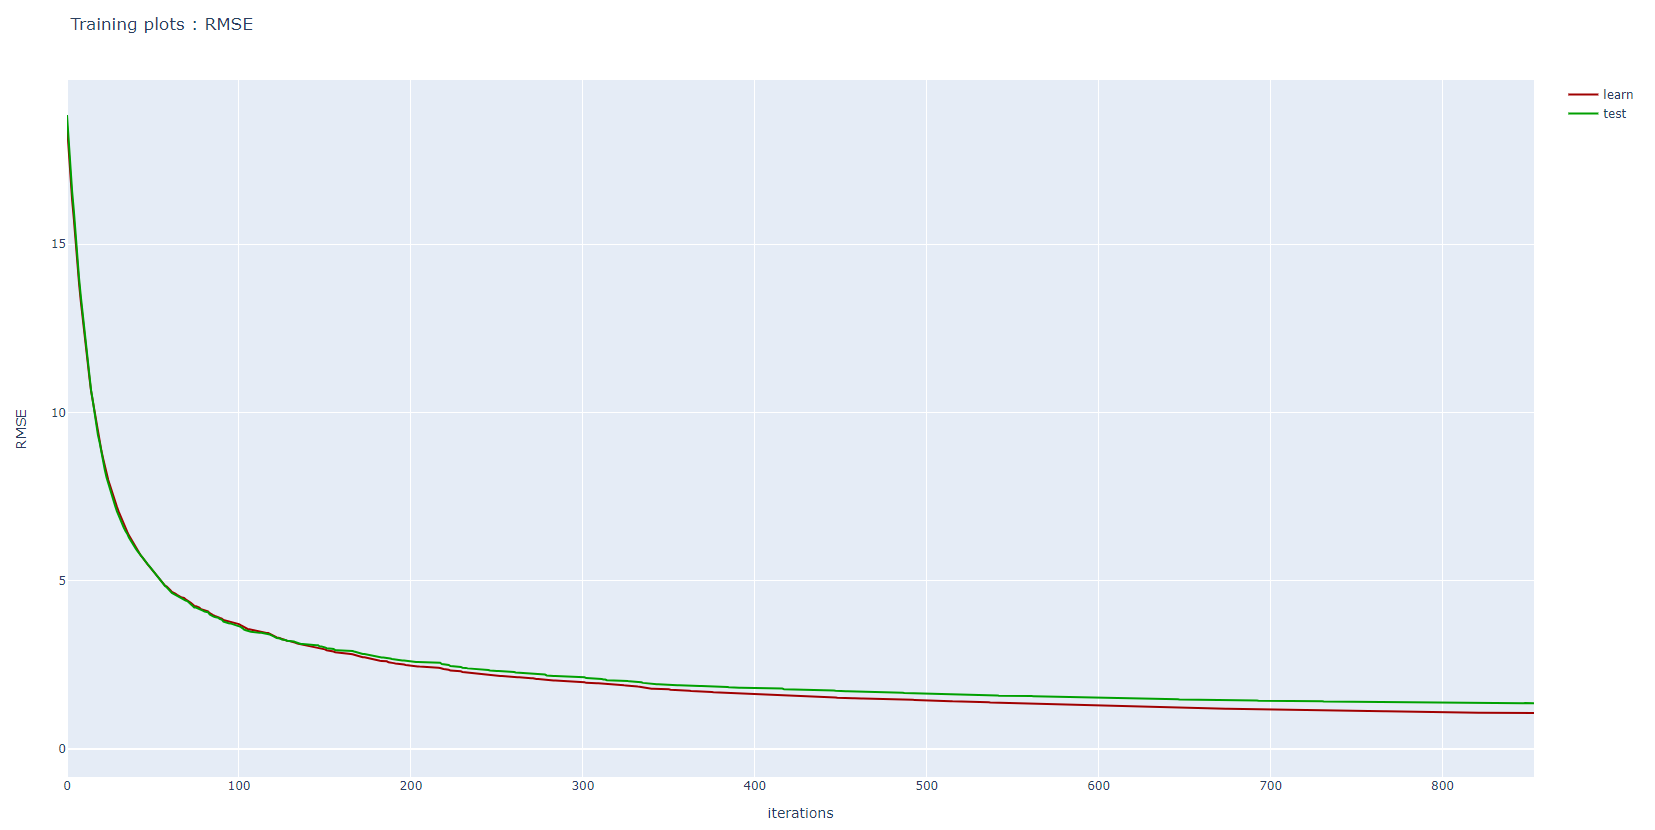

### 3.5. Explicabilité et Importance des features

On utilise les shap values pour regarder l'influence des varaibles sur la cible.

In [39]:
# Récupérer les valeurs shap
explainer = shap.TreeExplainer(cat_model_final)
shap_values = explainer.shap_values(X_train)

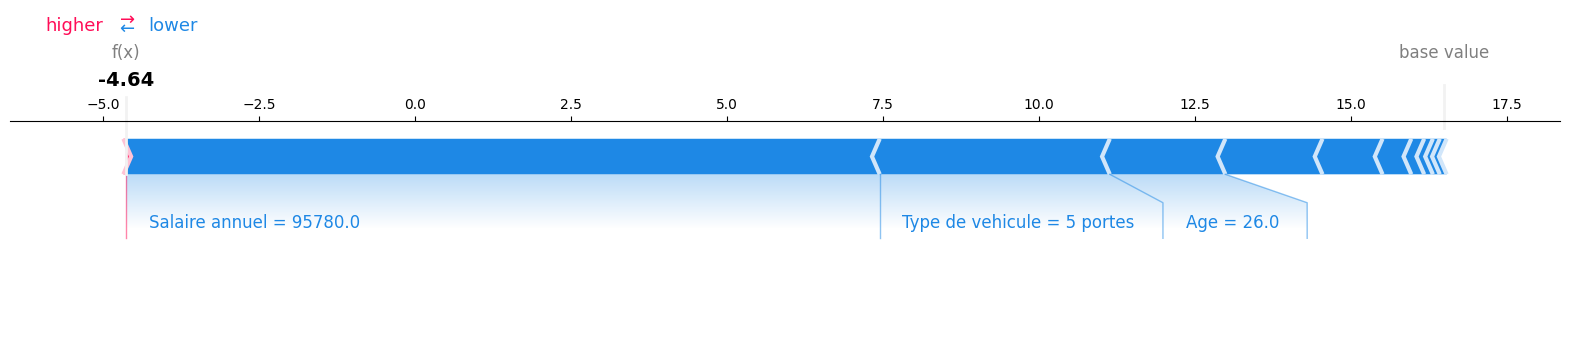

In [40]:
# Visualiser la prédiction sur la première ligne
shap.force_plot(explainer.expected_value, shap_values[0,:], X_train.iloc[0,:],
                matplotlib=True)

On peut regarder quels sont les variables qui ont contribué à prédire la valeur -4.45 pour cette ligne. La variable **Salaire annuel** suivi du **Type de véhicule** puis **Age** contribuent à pousser la valeur prédite aux valeurs inférieurs.

/usr/local/lib/python3.10/dist-packages/shap/plots/_beeswarm.py:699: UserWarning:

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored



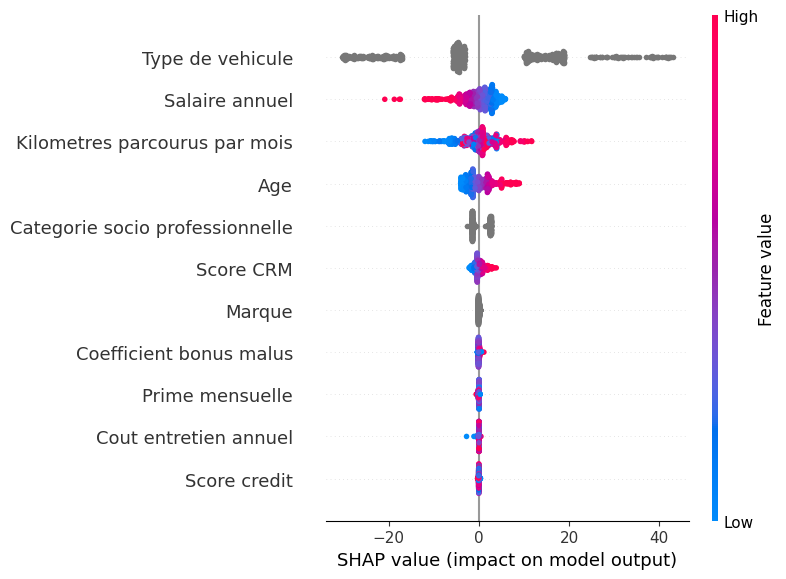

In [41]:
# Effet de toutes les variables
shap.summary_plot(shap_values, X_train)

**Ceci revalide la remarque qu'on a faite pendant l'analyse descriptive : que le Type de véhicule est un facteur discriminant pour déterminer la valeur du bénéfice.**

## 4. Prédiction

### 4.1 Traitement des données de soummision

La data de soumission doit subir les même chanqgement effectués sur la data d'entrainement pour qu'elle soit accceptable par le modèle

In [42]:
submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 13 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   index                            300 non-null    int64  
 1   Age                              296 non-null    float64
 2   Prime mensuelle                  299 non-null    float64
 3   Categorie socio professionnelle  300 non-null    object 
 4   Kilometres parcourus par mois    300 non-null    int64  
 5   Coefficient bonus malus          300 non-null    int64  
 6   Type de vehicule                 300 non-null    object 
 7   Score CRM                        300 non-null    int64  
 8   Niveau de vie                    300 non-null    int64  
 9   Marque                           284 non-null    object 
 10  Salaire annuel                   300 non-null    int64  
 11  Score credit                     300 non-null    int64  
 12  Cout entretien annuel 

#### 4.1.1. Colonnes supprimées

In [43]:
submission.drop(columns = ['Niveau de vie'], inplace = True)

#### 4.1.2. Valeurs manquantes

<u>Variable **Marque**<u/>

Nous renseignons les champs vides de la variable marque comme on l'a fait pour la base d'entrianement

In [44]:
# le nombre de champs vides dans la colonne Marque
num_missing = submission['Marque'].isnull().sum()

categories = train['Marque'].value_counts().to_dict()

N = sum(list(categories.values()))

cat_prob = {key : value/N for key, value in categories.items()}

# Générez des échantillons aléatoires pour remplir les champs vides
random_samples = np.random.choice(list(categories.keys()), size=num_missing, p=list(cat_prob.values()))

# Remplacer les champs vides par les échantillons aléatoires générés
submission.loc[submission['Marque'].isnull(), 'Marque'] = random_samples

<u>Variable **Age**<u/>

Nous regardons la correlation de la variable **Age** avec les autres variables.

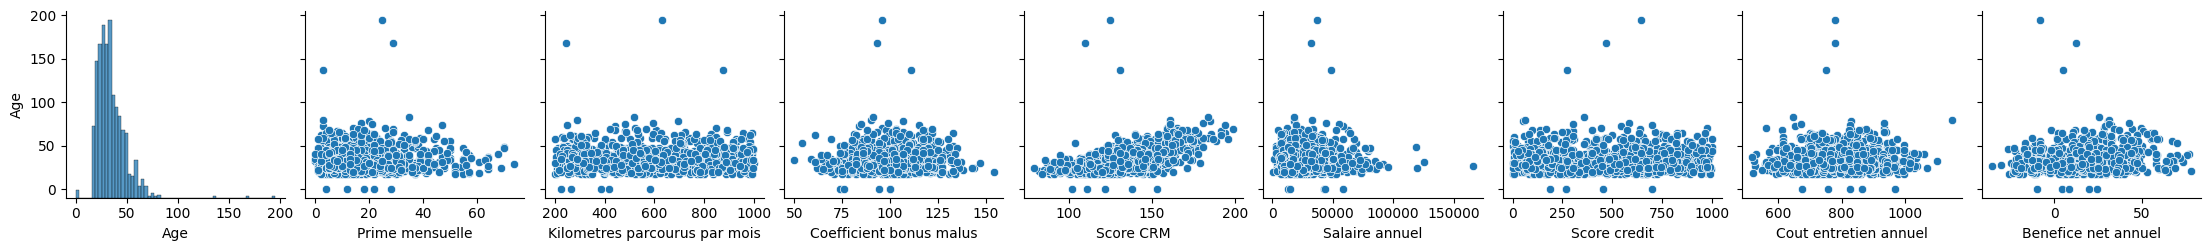

In [45]:
# Pour les variables numériques

sns.pairplot(train[[col for col in train.columns if col != 'index']], y_vars = ["Age"])
plt.show()

In [48]:
# Pour les variables catégorielles

cat_columns = train.select_dtypes(include=['object']).columns.tolist()
fig = make_subplots(rows=1,
              cols=len(cat_columns),
              subplot_titles=(cat_columns[0], cat_columns[1], cat_columns[2]),
               )

col1 = go.Box(x = train[cat_columns[0]], y=train["Age"], name =cat_columns[0])
col2 = go.Box(x = train[cat_columns[1]], y=train["Age"], name =cat_columns[1])
col3 = go.Box(x = train[cat_columns[2]], y=train["Age"], name =cat_columns[2])

fig.add_trace(col1, row = 1, col = 1)
fig.add_trace(col2, row = 1, col = 2)
fig.add_trace(col3, row = 1, col = 3)

# Limiter l'axe y à 85 pour chaque sous-graphique
fig.update_yaxes(range=[0, 85], row=1, col=1)
fig.update_yaxes(range=[0, 85], row=1, col=2)
fig.update_yaxes(range=[0, 85], row=1, col=3)

fig.update_layout(showlegend = False)
fig.show()

On choisit de générer un vecteur qui suit la loi de génération de la variable Age

In [49]:
# Générer un vecteur de 4 âge en imitant la loi dans la base d'entrainement
size = submission['Age'].isnull().sum()
np.random.seed(0)
mean = np.mean(train["Age"])
std = np.std(train["Age"])
generated_age = [int(elt) for elt in list(np.random.normal(mean, std, size))]
print("Vecteur age généré :", generated_age)

Vecteur age généré : [59, 40, 48, 66]


In [50]:
# Reseigner les champs vides
submission.loc[submission['Age'].isnull(), 'Age'] = generated_age

<u>Variable **Prime mensuelle**<u/>

On fait de même por la prime mensuelle

In [51]:
# Générer un vecteur prime mensuelle en imitant la loi dans la base d'entrainement
size = submission['Prime mensuelle'].isnull().sum()
np.random.seed(0)
mean = np.mean(train["Prime mensuelle"])
std = np.std(train["Prime mensuelle"])
generated_prime_mensuelle = list(np.random.normal(mean, std, size))
print("Vecteur prime mensuelle généré :", generated_prime_mensuelle)

Vecteur prime mensuelle généré : [42.088501063860015]


In [52]:
submission.loc[submission['Prime mensuelle'].isnull(), 'Prime mensuelle'] = generated_prime_mensuelle

### 4.2. Comparaison de data d'entrainement et data de prédiction

Afin de s'assurer que la data de prediction est cohérente avec celle d'entrainement (s'assurer par exemple que les instances des données catégorielles sont les mêmes). On procède à une comparaison des distributions, au moins pour les 4 ou 5 variables plus importantes pour le modèle.

In [53]:
def compare_distributions(train_df, submission_df, column, is_categorical):

  if not is_categorical :
    fig = make_subplots(rows=1,
                  cols=2,
                  subplot_titles=("Data d'entrainement", "Data de prédiction"),
                  x_title= column,
                  y_title=column,
                  shared_yaxes=True)
    train_dist = go.Box(y = train_df[column], name ='')
    pred_dist = go.Box(y = submission_df[column], name ='')

  else :
    fig = make_subplots(rows=1,
                  cols=2,
                  subplot_titles=("Data d'entrainement", "Data de prédiction"),
                  x_title= column,
                  y_title='Distribution')
    train_dist = go.Histogram(x = train_df[column],  histnorm='percent')
    pred_dist = go.Histogram(x = submission_df[column],  histnorm='percent')

  fig.add_trace(train_dist, row = 1, col = 1)
  fig.add_trace(pred_dist, row = 1, col = 2)

  fig.update_layout(showlegend=False, title_text=f"Distribution de {column}")
  fig.show()

In [54]:
compare_distributions(train, submission, "Type de vehicule", True)

In [55]:
compare_distributions(train, submission, "Salaire annuel", False)

In [56]:
compare_distributions(train, submission, "Kilometres parcourus par mois", False)

In [57]:
compare_distributions(train, submission, "Age", False)

In [58]:
compare_distributions(train, submission, "Categorie socio professionnelle", True)

**On remarque\ que que la distribution est la même pour les variables les plus importantes.**

### 4.3. Prédiction et soumission

In [59]:
# données de prédiction
X_pred = submission.drop(columns = ['index'])
y_pred = cat_model_final.predict(X_pred)

In [60]:
submission["Prediction_benefice"] = y_pred

In [61]:
# Enregistrer sous format csv
#submission[["index", "Prediction_benefice"]].to_csv('/content/drive/MyDrive/Study case/predictions.csv', index = False)